In [3]:
import xarray as xr
import numpy as np
from google.cloud import storage
import fsspec
from kerchunk.hdf import SingleHdf5ToZarr 
from kerchunk.combine import MultiZarrToZarr
from pathlib import Path
import ujson
from dask.distributed import Client, LocalCluster
from dask.diagnostics import ProgressBar
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scores
import pandas as pd
import seaborn as sns
import eccodes
import dask
import cfgrib
import herbie.accessors
import regionmask
import xskillscore
dask.config.set({'temporary_directory': '/mnt/disks/data/'})
sns.set_theme(style='whitegrid',context='talk')

Heatwave metrics need to emphasize the impact of duration and intensity. For intensity, RMSE is a valid metric that punishes outliers and is interpretable as similar to MAE for various users. RMSE can be applied regionally and at observation stations, therefore used as a metric for both.

Also, length of time in each forecast the: 1. observation location was above 85th percentile mean and 2. at least 25% of the region was above 85th percentile mean

Anomaly correlation will be used spatially to determine how well the model forecast anomalies between ERA5 and the AI model.

The only wrinkle left is what to compare these models against, but we can worry about that later?

In [4]:
fs_read = fsspec.filesystem('gcs', anon=False, skip_instance_cache=True)
fs_local = fsspec.filesystem('')  
json_dir = 'assets/json/'
json_list = fs_local.glob(str(json_dir)+'PANG*_.json')
so = dict(mode='rb', anon=True, default_fill_cache=False, default_cache_type='first')

def convert_longitude_to_360(longitude):
    return longitude % 360

def generate_json_from_grap_nc(u,fs, fs_out):
    with fs.open(u, **so) as infile:
        h5chunks = SingleHdf5ToZarr(infile, u, inline_threshold=300)

        file_split = u.split('/') # seperate file path to create a unique name for each json 
        model = file_split[1].split('_')[0]
        date_string = file_split[-1].split('_')[3]
        outf = f'{json_dir}{model}_{date_string}_.json'
        print(outf)
        with fs_out.open(outf, 'wb') as f:
            f.write(ujson.dumps(h5chunks.translate()).encode());

# seasonal aggregation functions for max, min, and mean
def seasonal_subset_max(df):
    df = df.where(df.index.month.isin([6,7,8]))
    return df.max()

def seasonal_subset_min(df):
    df = df.where(df.index.month.isin([6,7,8]))
    return df.min()

def seasonal_subset_mean(df):
    df = df.where(df.index.month.isin([6,7,8]))
    return df.mean()

def is_jja(month):
    return (month >= 6) & (month <= 8)

def is_6_hourly(hour):
    return (hour == 0) | (hour == 6) | (hour == 12) | (hour == 18)


# Load in gridded data

In [5]:
fs_ = fsspec.filesystem("reference", fo=json_list[0], ref_storage_args={'skip_instance_cache':True},
                       remote_protocol='gcs', remote_options={'anon':True})
m = fs_.get_mapper("")
ds = xr.open_dataset(m, engine="zarr", backend_kwargs={'consolidated':False}, chunks={})
ds['t2c'] = ds['t2']-273.15

pangu_t2c = ds['t2c'].compute()

In [36]:
era5 = xr.open_zarr(
    "gs://gcp-public-data-arco-era5/ar/1959-2022-full_37-1h-0p25deg-chunk-1.zarr-v2",
    chunks='auto',
    storage_options=dict(token='anon'),
)
era5_pnw_heatwave_2021 = era5[['2m_temperature']].sel(time=slice('2021-06-25','2021-06-29'))
era5_pnw_heatwave_2021 = era5_pnw_heatwave_2021.sel(time=is_6_hourly(era5_pnw_heatwave_2021['time.hour']))

In [ ]:
def subset_region_by_event(pangu_t2c):
    ar6_regions = regionmask.defined_regions.ar6.land
    # Get the mask for the specific region
    mask = ar6_regions.mask(pangu_t2c.longitude, pangu_t2c.latitude)

    # Create a mask for the 'Africa' region (you can check the specific ID for your region)
    wna_mask = mask == ar6_regions.abbrevs.index('WNA')
    land = regionmask.defined_regions.natural_earth_v5_0_0.land_110
    land_sea_mask = land.mask(pangu_t2c.longitude, pangu_t2c.latitude)

    ds_subset = pangu_t2c.where((wna_mask) & (land_sea_mask == 0), drop=True)
    return ds_subset



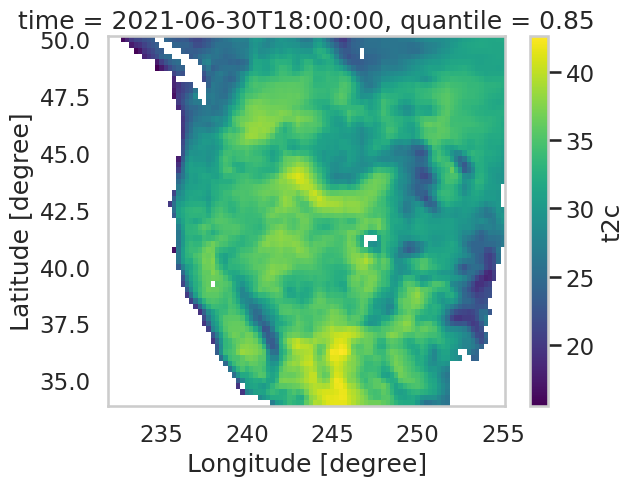

In [63]:
pangu_subset.where(pangu_subset > era5_85th['2m_temperature']-273.15).isel(time=39).plot()

# output_ehe_mask = xr.where((daily_max_temp > era5_climatology_85) &  
#                            (prev_day_max_temp > era5_climatology_85) &
#                            (land_sea_mask == 0),
#                            1,
#                            0)

In [ ]:
era5_85th = xr.open_zarr('/home/taylor/data/era5_2m_temperature_85th_percentile_1989-2019.zarr', chunks='auto')
era5_85th = subset_region_by_event(era5_85th)

In [ ]:
era5_85th = xr.open_zarr('/home/taylor/data/era5_2m_temperature_85th_percentile_1989-2019.zarr', chunks='auto')
era5_85th = subset_region_by_event(era5_85th)

for json_file in json_list:
    fs_ = fsspec.filesystem("reference", fo=json_file, ref_storage_args={'skip_instance_cache':True},
                       remote_protocol='gcs', remote_options={'anon':True})
    m = fs_.get_mapper("")
    ds = xr.open_dataset(m, engine="zarr", backend_kwargs={'consolidated':False}, chunks={})
    pangu_subset = subset_region_by_event(pangu_t2c)
    era5_pnw_heatwave_2021_subset = subset_region_by_event(era5_pnw_heatwave_2021)
    # 1. Generate duration event

KeyboardInterrupt: 

# Load in Climatology Data